In [10]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import interpolate
from datetime import datetime as dt
import cmocean
import datetime
from matplotlib.dates import DateFormatter
import glob
import math
from astropy.convolution import convolve
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib as mpl
import matplotlib.dates as mdates
# from scipy.optimize import curve_fit
from numpy.lib.stride_tricks import sliding_window_view

myFmt = mdates.DateFormatter('%m-%d')

From discussion with Matt, Michael, Chris: calculate "cold content", or some variation of accumulated energy/energy to melt/etc, and the depth over which to calculate it based on variability

In [3]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()

    return out_vars

In [4]:
def round_down_to_even(f):
    if np.isnan(f):
        return np.nan
    else:
        return 2 * (f // 2)

In [7]:
def round_up_to_even(f):
    if np.isnan(f):
        return np.nan
    else:
        return math.ceil(f / 2.) * 2

In [12]:
def rolling_std(a, window, axis=-1, ddof=1):
    """
    Calculates the rolling standard deviation along a specified axis.

    Args:
        a (np.ndarray): The input array.
        window (int): The size of the rolling window.
        axis (int, optional): The axis along which to calculate the rolling std. Defaults to -1.
        ddof (int, optional): Delta degrees of freedom. The divisor used in calculations is N - ddof,
                             where N represents the number of elements. By default ddof is one.

    Returns:
        np.ndarray: An array of the rolling standard deviations.
                      The size of the returned array along the rolling axis is smaller by window - 1.

    From google AI
    """

    if window > a.shape[axis]:
      raise ValueError("Window size cannot exceed the length of the specified axis.")

    # Create a sliding window view of the array
    shape = np.array(a.shape)
    shape[axis] = shape[axis] - window + 1
    
    strides = np.array(a.strides)
    
    new_view = np.lib.stride_tricks.as_strided(a, shape = tuple(shape) + (window,), strides = tuple(strides) + (strides[axis],))

    # Calculate the standard deviation along the last axis (the window axis)
    return np.ma.std(new_view, axis=-1, ddof=ddof)

## Load SIMBA data, which will at some point be corrected

In [5]:
simba_filepath = '/psd3data/arctic/raven/simba/level1/'
lev1_files = glob.glob(simba_filepath+'*.nc')
lev1_files.sort()

## on our server the simba files include some days from march during testing; this gets rid of those files
lev1_files = lev1_files[5:]

## these are the only variables I've used so far from the SIMBA
varnames = ['temperature','height','time']

season_data = {}

for fname in lev1_files[:]:
    fdic = load_netcdf(fname, varnames)

    fstart_time = dt.strptime(fdic['time_unit'][-19:], '%Y-%m-%d %H:%M:%S')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])

    for var in ['temperature','dates']:
        if var not in season_data:
            season_data[var] = fdic[var]
        else:
            season_data[var] = np.ma.concatenate( (season_data[var], fdic[var]), axis=0 )

    ## only want one height:
    if 'height' not in season_data:
        season_data['height'] = fdic['height']
        

In [8]:
with np.load('/home/asledd/ICECAPS/Raven_SIMBA_sfc-id_max-T-grad.npz') as npz:
    simba_sfc_heights = np.ma.MaskedArray(**npz)

## I know this has 15 minute time steps, so average over several hours
kernel_avg_hrs= [1./(4*6+1)]*(4*6+1)

simba_sfc = convolve(simba_sfc_heights, kernel_avg_hrs, boundary='extend')
# simba_sfc = np.ma.masked_invalid([round_up_to_even(height) for height in simba_sfc])

simba_sfc = np.ma.masked_invalid([round_up_to_even(height) for height in simba_sfc]) ## can also do round_down_to_even()

## this was a day with quick accumulation that gets unrealistically smoothed in the surface height
simba_sfc = np.ma.masked_where((season_data['dates']>=dt(2024,6, 25))&(season_data['dates']<dt(2024,6, 26)), simba_sfc)

## based on solar correction, this surface identification might be over estimated
simba_sfc -= 6.
simba_sfc_heights -= 6.


In [9]:
simba_temp = season_data['temperature']
simba_dates = season_data['dates']
simba_depths = season_data['height']

In [13]:
print(simba_temp.shape, simba_dates.shape)

(9504, 241) (9504,)


In [14]:
temps_rolling_std = rolling_std(simba_temp, 4*24, axis=0)

In [21]:
print(temps_rolling_std.shape, simba_dates[4*24-1:].shape)

(9409, 241) (9409,)


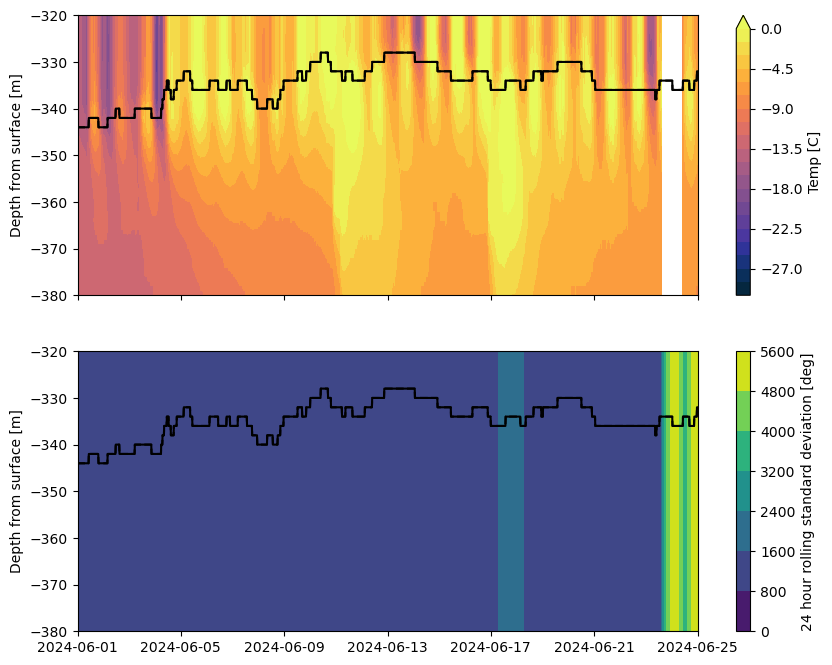

In [23]:
fig, axs = plt.subplots(2, figsize=(10,8), sharex=True, sharey=True)
cb = axs[0].contourf(simba_dates, simba_depths, np.swapaxes(simba_temp,0,1), 
                     cmap=cmocean.cm.thermal, levels=np.linspace(-30,0,21), extend='max')
plt.colorbar(cb, label='Temp [C]', ax=axs[0])

# think the dates are off slightly
cb = axs[1].contourf(simba_dates[4*24-1:], simba_depths, np.swapaxes(temps_rolling_std,0,1))#, levels=np.arange(0,5.01,.5), extend='max')
plt.colorbar(cb, label='24 hour rolling standard deviation [deg]', ax=axs[1])


axs[0].set_ylim(-380,-320)
axs[0].set_xlim(dt(2024,6,1),dt(2024,6,25))
for ax in axs.ravel():
    ax.plot(simba_dates, simba_sfc, c='k')
    ax.plot(simba_dates, simba_sfc, c='k', ls='--')

    ax.set_ylabel('Depth from surface [m]')
plt.show()